In [26]:
import math
from enum import Enum
from scipy import optimize
import bisect
from scipy.interpolate import CubicSpline
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp        
import pandas as pd
import re

In [27]:
# option type call and put
class PayoffType(Enum):
    Call = 0
    Put = 1

In [28]:
# cdf of nomral distribution
def cnorm(x):
    return (1.0 + math.erf(x/ math.sqrt(2.0)))/2.0

In [29]:
# output is forward delta
#
def fwdDelta(fwd, stdev, strike, payoffType):  # stdev != vol 
    d1 = math.log(fwd/ strike)/ stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    if payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

In [30]:
# use root search ( brentq) to find strike given delta of market
def strikeFromDelta(S,r,q,T,vol,delta, payoffType):
    fwd = S * math.exp((r-q)*T)
    if payoffType == PayoffType.Put: 
        delta = -delta
    f = lambda K:(fwdDelta(fwd, vol*math.sqrt(T), K, payoffType) - delta)
    a,b = 0.00001, 100000
    return optimize.brentq(f,a,b)

In [31]:
class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # time interpolation
    def Vol(self, t, k): # for each maturity we have a volatility smile
        pos = bisect.bisect_left(self.ts, t)
        # avoid calender arbitrage
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return
    # for the implementation of local vol
    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.001) - self.Vol(t, k-0.001)) / 0.002
    def dVoldT(self, t, k):
        return (self.Vol(t + 0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.001) + self.Vol(t, k-0.001) - 2*self.Vol(t, k)) / 0.000001


In [32]:
class LocalVol:
    def __init__(self, iv, S0, r, q):
        self.iv = iv # implied vol
        self.S0 = S0 # foward price?
        self.r = r
        self.q = q
    
    def LV(self, t, s): # s is strike
        if t< 1e-6:
            return self.iv.Vol(t,s)
        imp = self.iv.Vol(t,s)
        dvdk = self.iv.dVoldK(t,s)
        dvdt = self.iv.dVoldT(t,s)
        d2vdk2 = self.iv.dVol2dK2(t,s)
        d1 = (math.log(self.S0/s) + (self.r-self.q)*t + imp * imp * t /2) / imp / math.sqrt(t)
        numerator = imp * imp +2 *t *imp* dvdt + 2*(self.r - self.q)*s*t*imp * dvdk
        denominator = (1 + s * d1 * math.sqrt(t)*dvdk)**2 + s *s *t * imp*(d2vdk2 - d1 *math.sqrt(t)*dvdk*dvdk)
        # avoid calendar arbitrage
        localvar = min(max(numerator/denominator, 1e-8),1.0)
        if numerator < 0:
            localvar = 1e-8
        if denominator < 0:
            localvar = 1.0
        return math.sqrt(localvar)

In [33]:
class EuropeanOption():
    def __init__(self, assetName, expiry, strike, payoffType):
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported:", self.payoffType)
        
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

In [34]:
def bsPrice(S,r,q,vol,T,strike,payoffType):
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) *(fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) *(strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

In [35]:
def pdePricerX(S0, r, q, lv, NX, NT, w, trade):
    mu = r-q
    T = trade.expiry
    X0 = math.log(S0)
    vol0 = lv.LV(0,S0) # local vol LV(t=0, k=S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - vol0 * vol0 * 0.5) * T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5)*T - srange
    dt = T/(NT-1)
    dx = (maxX - minX) / (NX - 1)
    # spot grid
    xGrid = np.array([minX + i*dx for i in range(NX)])
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    
    for j in range(1,NT):
        M = np.zeros((NX, NX))
        D = np.zeros((NX,NX))
        for i in range(1, NX - 1):
            vol = lv.LV(j*dt, math.exp(xGrid[i]))
            M[i, i-1] = (mu - vol *vol / 2.0)/ 2.0/ dx - vol*vol / 2/dx/dx
            M[i, i] = r + vol * vol / dx /dx
            M[i, i+1] = -(mu - vol * vol/ 2.0)/ 2.0/dx - vol * vol /2 / dx/ dx
            D[i,i] = 1.0
        M[0,0], M[NX -1, NX -1] = 1.0, 1.0
        rhsM = (D - dt*M) * w + (1-w) * np.identity(NX)
        lhsM = w*np.identity(NX) + (D + dt*M) *(1 - w)
        inv = np.linalg.inv(lhsM)
        
        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r * j * dt) * trade.payoff(math.exp(xGrid[0]))
        ps[NX-1] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[NX-1]))
        ps = inv.dot(ps)
    return np.interp(X0, xGrid, ps)

### Interporation

 **Constraints**
 - Cubic spline interpolation imposes the constraints that the left and right first derivative of a point have to match, it can be derived by matching the first  derivative of the left and right segments for point $i$ we have the condition

   \begin{align}
   c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
   \end{align}

   The cubic spline constraints translate to the linear system

   \begin{align} \underbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
   \end{pmatrix}}_{\vec{Q}_{(N-2) \times N}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N
   \end{pmatrix} =
   \underbrace{u^2
   \begin{pmatrix}
   \frac23 & \frac16 & 0 & \ldots & 0 \\
   \frac16 & \frac23 & \frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
   0 & \ldots & 0 & \frac 1 6 &  \frac23
   \end{pmatrix}}_{\vec{R}_{(N-2) \times (N-2)}}
   \begin{pmatrix}
   p_2 \\
   p_3 \\
   \vdots \\
   p_{N-1}
   \end{pmatrix}
   \end{align}

   If we define
   \begin{align}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
   \end{align}

   we can represent the constraint as:
   \begin{align}
   \vec{Ax} = \vec{0}        ~~~\textbf{--- Constraint 1}
   \end{align}

 - The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
   \begin{align}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1}
   ~~~\textbf{--- Constraint 2}
   \end{align}

   where

   \begin{align}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
   \end{align}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

 - $p_i$ are densities, so

    \begin{align}
    p_i > 0 ~~~\textbf{--- Constraint 3}
    \end{align}

 - Integrating the density function we should get 1.0 (recall that density function are linearly interpolated)

    \begin{align}
    u \sum p_i = 1.0 ~~~\textbf{--- Constraint 4}
    \end{align}

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align}

 - Call prices are monotonically decreasing:

    \begin{align}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align}


 **Objective Function**

 - Fill the rest of the DOF using objective function (soft constraints)

 - [Fengler 2009] tried minimizing the below to achieve smoothness on $p$:

    \begin{align}
    \int_{k_1}^{k_N} p(S)^2 dS = \text{constant} \times \vec{p}^{\top} \vec{R} \vec{p}
    \end{align}

    Using $\vec{x}$ as variable and define

    \begin{align}
    \vec{H}_{(2N-2) \times (2N-2)} =
    \begin{pmatrix}
    \vec{0} & \vec{0} \\
    \vec{0} & \vec{R}_{(N-2) \times (N-2)}
    \end{pmatrix}
    \end{align}

    the problem becomes minimizing

    \begin{align}
    \vec{x}^\top \vec{H} \vec{x}
    \end{align}

In [36]:
# for constrain 2
def bsPrice_fwd(fwd, vol, T, strike, payoffType):
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

In [37]:
class SmileAF:
    def __init__(self,strikes, vols, T):
        self.atmvol = vols[int(len(vols)/2)]
        self.fwd = strikes[int(len(vols)/2)]
        self.T = T
        self.N = 50
        stdev = self.atmvol * math.sqrt(T)
        kmin = self.fwd * math.exp(-0.5*stdev*stdev - 5 * stdev)
        kmax = self.fwd * math.exp(-0.5*stdev*stdev + 5 * stdev)
        u = (kmax - kmin) / (self.N -1)
        self.ks = [kmin +u* i for i in range(0, self.N)]
        self.u = u
        self.cs = np.zeros(self.N)  
        self.ps = np.zeros(self.N)
        #  arbitrage free

        Q = []
        for i in range(0,self.N-2):
            q_list =  [0]*self.N
            q_list[i] = 1
            q_list[i+1] = -2
            q_list[i+2] = 1
            Q.append(q_list)
        Q = np.array(Q)

        # R
        list_1 = [0]*(self.N-2)
        list_1[0] = 2/3
        list_1[1] = 1/6

        R = [list_1]
        for i in range(0,self.N-4):
            r_list = [0]*(self.N-2)
            r_list[i] = 1/6
            r_list[i+1] = 2/3
            r_list[i+2] = 1/6
            R.append(r_list)

        list_last = [0]*(self.N-2)
        list_last[-1] = 2/3
        list_last[-2] = 1/6
        R.append(list_last)
        R = np.array(R)*u*u
        # con 1
        A = np.block([Q,-R])
        # con2
        pos = [bisect.bisect_left(self.ks,strikes[i]) for i in range(0,len(strikes))]
        ki_1 = [self.ks[pos[i]] for i in range(0,len(pos))]
        a = [(ki_1[i] - strikes[i])/u for i in range(0,len(pos))]
        b = [1-a[i] for i in range(0,len(pos))]
        c = np.zeros((self.N,1))
        p = np.zeros(((self.N-2),1))
        store_array = []
        for k in range(len(pos)):
            i = pos[k]
            array_c = c.copy()
            array_c[i-1] = a[k]
            array_c[i] = b[k]
            array_p = p.copy()
            array_p[i-1] = ((a[k]**3 - a[k]) * u*u)/6
            array_p[i] = ((b[k]**3 - b[k]) * u*u)/6
            array = np.block([[array_c],[array_p]])
            store_array.append(array)
        A_2 = np.block(store_array).T
        b_2 = np.block([bsPrice_fwd(self.fwd, vols[i], T, strikes[i], PayoffType.Call) for i in range(len(strikes))])
        # con 3
        store_array = []
        for i in range(self.N,2*self.N-2):
            array = np.zeros((2*self.N-2,1))
            array[i] = -1
            store_array.append(array)
            G_3 = np.block(store_array).T
        # con4
        A_4 =  np.block([np.zeros(self.N),u * np.ones((1,(self.N-2)))])
        b_4 = np.array(1)
        # con 5
        c1 = c.copy()
        c1[0] = 1
        A_51 = np.block([[c1],[p]]).T
        b_51 = np.array(self.fwd - kmin)
        cn = c.copy()
        cn[self.N-1] = 1
        A_5n = np.block([[cn],[p]]).T
        b_5n = np.array(0)
        A_5 = np.block([[A_51],[A_5n]])
        # con 6 
        store_array = []
        for i in range(0,self.N-1):
            array = np.zeros((2*self.N-2,1))
            array[i] = -1
            array[i+1] = 1
            store_array.append(array)
        G_6 = np.block(store_array).T
        # CVXOPT QP problem
        H = matrix(np.pad(R,(self.N,0),'constant'))
        q = matrix(np.zeros((2*self.N-2,1)))
        G = matrix(np.block([[G_3],[G_6]]))
        h = matrix(np.zeros((2*self.N-3,1)))
        A = matrix(np.block([[A],[A_2],[A_4],[A_5]]))
        b = matrix(np.block([np.zeros(self.N - 2),b_2,1,b_51,0]))
        sol=solvers.qp(P=H,q=q,G=G,h=h,A=A,b=b)
        self.cs = sol['x'][:self.N]
        self.ps = self.ps.reshape(self.N,1)
        self.ps[1:-1] = sol['x'][self.N:] 
        
        def implyVol(k, prc,v):
            stdev = v* math.sqrt(self.T)
            d1 = (math.log(self.fwd/k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd/k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k* cnorm(d2) - prc
        
        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_left(self.ks, strikes[len(strikes) - 1])
        kks = [0] * ((khmax+1) - (khmin - 1) + 2)
        vs = [0] * ((khmax+1) - (khmin-1) + 2)
        for i in range(khmin-1, khmax+1):
            prc = self.Price(self.ks[i])
            f = lambda v: implyVol(self.ks[i], prc, v)
            a, b = 1e-8, 10
            vs[i - (khmin-1) + 1] = optimize.brentq(f,a,b)
            kks[i - (khmin-1) + 1] = self.ks[i]
        # improvement
        kks[0] = kmin
        vs[0] = vs[1]
        kks[len(kks) - 1] = kmax
        vs[len(vs) - 1] = vs[len(vs) - 2]
        self.kks = kks
        self.vs = vs
        self.cubicVol = CubicSpline(kks, vs, bc_type=((1,0.0), (1,0.0)),extrapolate=True)
        
    def Vol(self, k):
        if k< self.ks[0]:
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            return self.cubicVol(k)
         
    def Price(self, k):
        if k <= self.ks[0]:
            return self.fwd - k
        if k >= self.ks[self.N - 1]:
            return 0.0
        pos = bisect.bisect_left(self.ks, k)
        a = (self.ks[pos] - k) / self.u
        b= 1-a
        c = (a*a*a - a) * self.u * self.u / 6.0
        d = (b*b*b - b) * self.u * self.u / 6.0
        return a *self.cs[pos-1] + b * self.cs[pos] + c*self.ps[pos-1] + d*self.ps[pos]

In [38]:
class SmileCubicSpline:
    def __init__(self, strikes, vols):
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2])/ 10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1,0.0), (1, 0.0)), extrapolate = True)
    
    def Vol(self,k):
        if k < self.strikes[0]:
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

In [39]:
def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10, smileInterpMethod):
    c25 = bf25 + atmvol + rr25/2
    p25 = bf25 + atmvol - rr25/2
    c10 = bf10 + atmvol + rr10/2
    p10 = bf10 + atmvol - rr10/2
    
    ks = [strikeFromDelta(S,r,q,T, p10, 0.1, PayoffType.Put),
             strikeFromDelta(S,r,q,T, p25, 0.25, PayoffType.Put),
             S * math.exp((r-q) * T),
             strikeFromDelta(S,r,q,T, c25, 0.25, PayoffType.Call),
             strikeFromDelta(S,r,q,T, c10, 0.1, PayoffType.Call)]
    if smileInterpMethod == 'CUBICSPLINE':
        return SmileCubicSpline(ks, [p10,p25,atmvol,c25, c10])
    elif smileInterpMethod == 'AF':
        return SmileAF(ks, [p10, p25, atmvol, c25,c10], T)

In [40]:
# import data
data = pd.read_csv('usdjpy0316.csv')
data.columns = data.iloc[0]
data = data.dropna()
data.index = data.iloc[:,0]
data = data.drop(np.nan, axis=1)
data = data.apply(pd.to_numeric)/100
data['pillar'] = data.index
data = data.reset_index(drop=True)
data = data[['pillar', 'ATM', '25D RR', '25D BF', '10D RR','10D BF']]
data.index = data.pillar
data.head()

,pillar,ATM,25D RR,25D BF,10D RR,10D BF
pillar,,,,,,
1D,1D,0.23220,-0.02640,0.00515,-0.05425,0.01465
1W,1W,0.17900,-0.02240,0.00415,-0.04280,0.01195
2W,2W,0.15610,-0.02060,0.00400,-0.04060,0.01170
3W,3W,0.14625,-0.01942,0.00348,-0.03890,0.01110
1M,1M,0.13930,-0.01935,0.00390,-0.03760,0.01245


In [41]:
time = pd.DataFrame()
time['num'] = data['pillar'].apply(lambda x: re.findall("\d+", str(x))[0]).apply(lambda x: pd.to_numeric(x))
time['alpha'] =data['pillar'].apply(lambda x: re.findall(r'[A-Za-z]+', str(x))[0])
time['tenor'] = time['alpha'].apply(lambda x: 7 if x == 'W' else 30 if x =='M' else 365 if x=='Y' else 1) / 365
time['pillar'] = round(time['num'] * time['tenor'], 2)
time.head()

,num,alpha,tenor,pillar
pillar,,,,
1D,1,D,0.002740,0.00
1W,1,W,0.019178,0.02
2W,2,W,0.019178,0.04
3W,3,W,0.019178,0.06
1M,1,M,0.082192,0.08


In [42]:
data['pillar'] = time['pillar']
data

,pillar,ATM,25D RR,25D BF,10D RR,10D BF
pillar,,,,,,
1D,0.00,0.23220,-0.02640,0.00515,-0.05425,0.01465
1W,0.02,0.17900,-0.02240,0.00415,-0.04280,0.01195
2W,0.04,0.15610,-0.02060,0.00400,-0.04060,0.01170
3W,0.06,0.14625,-0.01942,0.00348,-0.03890,0.01110
1M,0.08,0.13930,-0.01935,0.00390,-0.03760,0.01245
2M,0.16,0.14265,-0.02230,0.00420,-0.04460,0.01370
3M,0.25,0.13840,-0.02178,0.00437,-0.04410,0.01410
4M,0.33,0.13043,-0.01915,0.00427,-0.03865,0.01395
5M,0.41,0.12629,-0.01751,0.00435,-0.03548,0.01445


In [43]:
# sc is to control smile
def createTestImpliedVol(S, r, q, sc, df,smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.74, 1.0, 1.48, 2, 3, 5]
    df = df[df.pillar.isin(pillars)]
    atmvols = list(df['ATM'].values)
    bf25s = list(df['25D BF'].values)
    rr25s = list(df['25D RR'].values)
    bf10s = list(df['10D BF'].values)
    rr10s = list(df['10D RR'].values)
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i]*sc, rr25s[i]*sc, bf10s[i]*sc, rr10s[i]*sc, smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

In [55]:
# iv <- ImpliedVol(pillars, smiles)
def plotTestImpliedVolSurface(iv):
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S * math.exp((r-q) * tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)
    
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    
    lv = LocalVol(iv, S, r, q)
    lvs = np.ndarray((len(ts),len(ks)))
    
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i,j] = iv.Vol(ts[i],ks[j]) # implied vol
            lvs[i,j] = lv.LV(ts[i], ks[j]) # local vol
    
    # visulization
    hf = plt.figure(figsize=(16,8), dpi=80)
    ha = hf.add_subplot(121, projection = '3d')
    hb = hf.add_subplot(122, projection = '3d')
    X, Y = np.meshgrid(ks, ts)
    # plot implied vol
    ha.plot_surface(X, Y, vs)
    ha.view_init(azim=30)
    ha.set_title('implied vol')
    ha.set_xlabel('strike')
    ha.set_ylabel('T')
    # plot local vol
    hb.plot_surface(X,Y,lvs)
    hb.view_init(azim=30)
    hb.set_title('local vol')
    hb.set_xlabel('strike')
    hb.set_ylabel('T')
    plt.show()

In [58]:
def pdeCalibReport(S0, r, q, impliedVol):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1) # delta
    err = np.zeros((len(ds), len(ts)))
    
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_xticklabels(map(lambda t: round(t,2), ts))
    ax.set_yticklabels(map(lambda d: round(d,1), ds))
    
    lv = LocalVol(impliedVol, S0, r, q)
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, iv.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put)
            # why vol is iv.Vol(T, S0*math.exp(r*T)) and use put option
            trade = EuropeanOption("ASSET1", T, K, PayoffType.Put)
            vol = impliedVol.Vol(ts[j], K)
            bs = bsPrice(S0, r, q, vol, T, K, PayoffType.Put)
            pde = pdePricerX(S0, r, q, lv, max(50, int(50*T)), max(50, int(50*T)), 0.5, trade)
            err[i,j] = math.fabs(bs-pde)/ S0 * 10000 # i basis per 1 unit of stock
            ax.text(j,i,round(err[i,j],1), ha='center', va='center', color='w')
    im = ax.imshow(err)
    ax.set_title('Dupire Calibration PV Error Matrix')
    fig.tight_layout()
    plt.show()

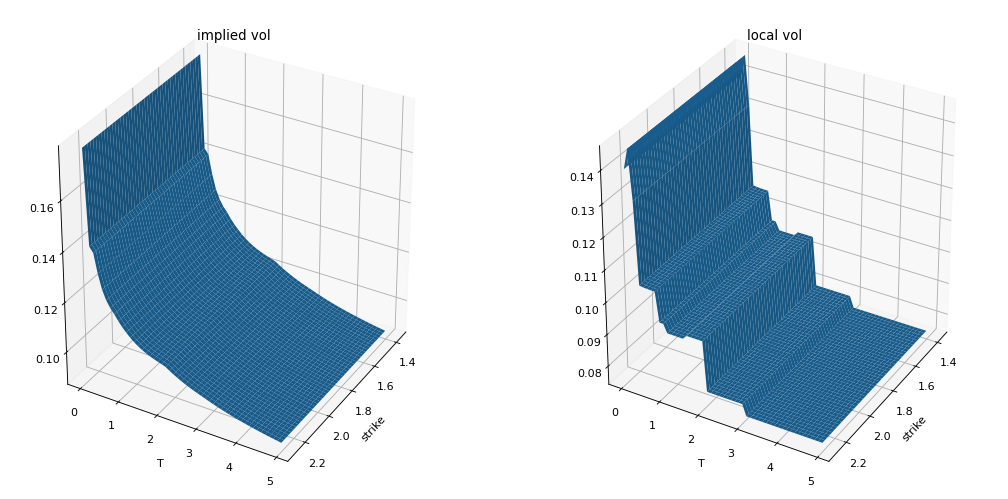

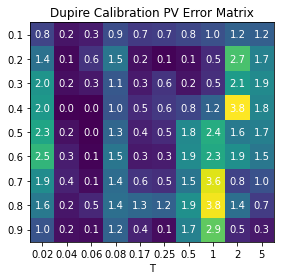

In [59]:
S, r, q = 1.3645, 0.0475, -0.001
iv = createTestImpliedVol(S, r, q, sc = 0.0,df=data,smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

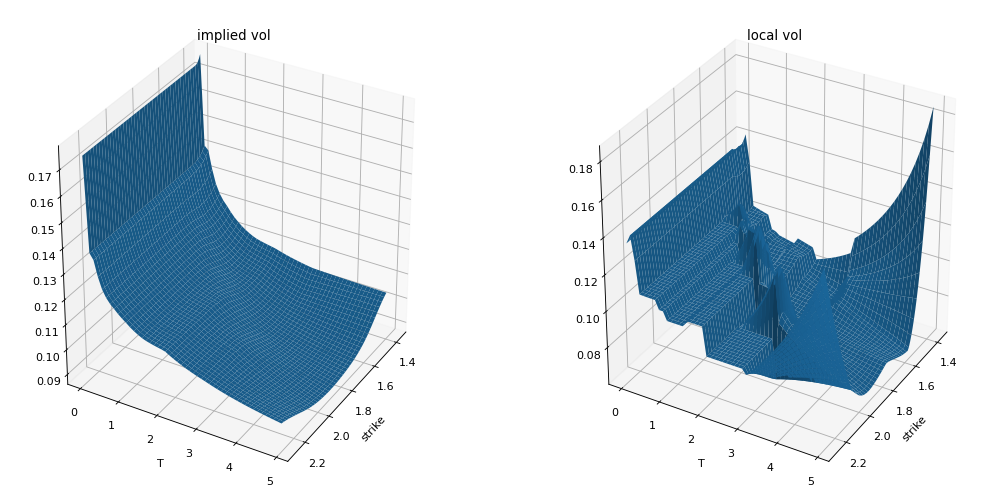

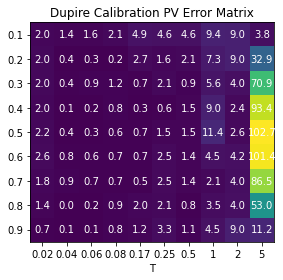

In [60]:
iv = createTestImpliedVol(S, r, q, sc = 0.5, df= data,smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

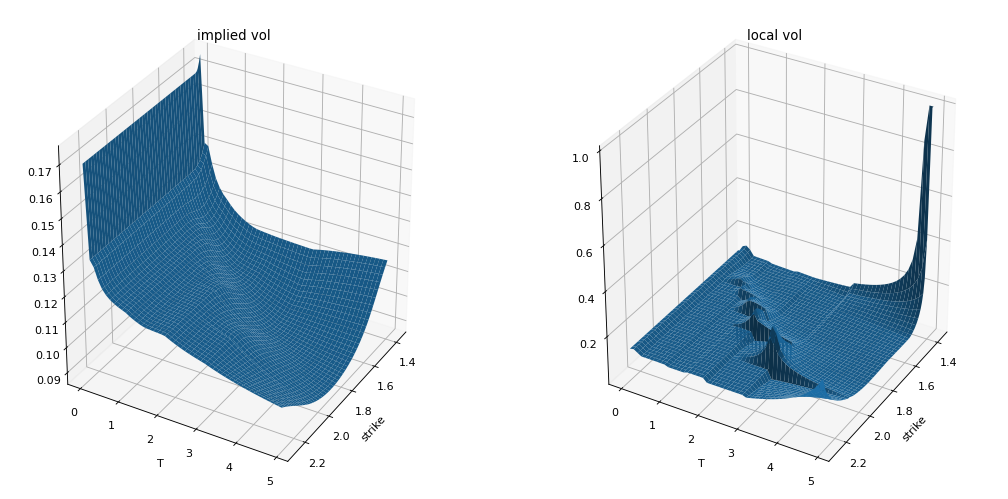

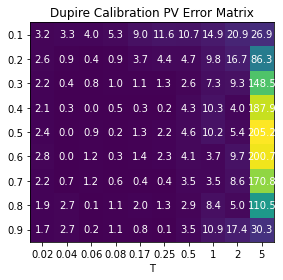

In [61]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, df= data,smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

     pcost       dcost       gap    pres   dres
 0:  2.8130e-02 -6.3981e+02  3e+03  2e+01  9e+01
 1:  2.8602e-02 -1.0839e+02  2e+02  1e+00  6e+00
 2:  3.1389e-02 -2.6181e+01  3e+01  1e-02  6e-02
 3:  3.1401e-02 -6.0843e-01  6e-01  3e-04  1e-03
 4:  3.0651e-02 -1.3898e-01  2e-01  6e-05  3e-04
 5:  2.9794e-02  1.0483e-02  2e-02  6e-06  3e-05
 6:  2.9198e-02  2.5721e-02  3e-03  8e-07  4e-06
 7:  2.8906e-02  2.8272e-02  6e-04  1e-07  4e-07
 8:  2.8783e-02  2.8672e-02  1e-04  1e-08  5e-08
 9:  2.8747e-02  2.8736e-02  1e-05  4e-10  2e-09
10:  2.8743e-02  2.8742e-02  5e-07  8e-12  4e-11
11:  2.8743e-02  2.8743e-02  2e-08  2e-13  1e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.8180e-02 -4.3402e+02  2e+03  2e+01  7e+01
 1:  2.8613e-02 -7.9224e+01  2e+02  1e+00  5e+00
 2:  3.0656e-02 -1.6431e+01  2e+01  2e-02  6e-02
 3:  3.0669e-02 -4.4709e-01  5e-01  4e-04  1e-03
 4:  3.0103e-02 -5.5319e-02  9e-02  3e-05  1e-04
 5:  2.9497e-02  1.8998e-02  1e-02  3e-06  1e-0

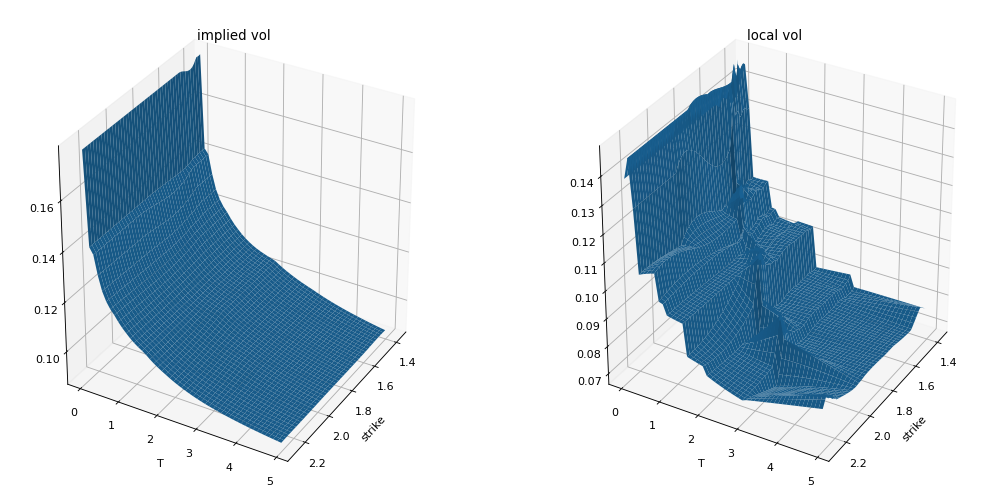

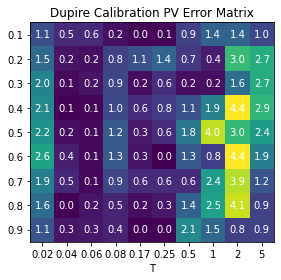

In [62]:
iv = createTestImpliedVol(S, r, q, sc = 0.0, df= data,smileInterpMethod='AF')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

     pcost       dcost       gap    pres   dres
 0:  2.9258e-02 -8.0001e+02  3e+03  2e+01  1e+02
 1:  2.9512e-02 -1.2650e+02  2e+02  8e-01  4e+00
 2:  3.0008e-02 -1.1252e+01  1e+01  8e-03  4e-02
 3:  3.0008e-02 -6.5910e-01  7e-01  5e-04  3e-03
 4:  3.1671e-02 -3.4666e-01  4e-01  2e-04  1e-03
 5:  3.1481e-02 -2.1580e-02  5e-02  2e-05  1e-04
 6:  3.0905e-02  1.5656e-02  2e-02  3e-06  2e-05
 7:  3.0318e-02  2.5797e-02  5e-03  5e-07  3e-06
 8:  2.9962e-02  2.8680e-02  1e-03  7e-08  4e-07
 9:  2.9763e-02  2.9499e-02  3e-04  3e-09  2e-08
10:  2.9698e-02  2.9654e-02  4e-05  6e-15  7e-15
11:  2.9685e-02  2.9682e-02  3e-06  4e-15  8e-15
12:  2.9684e-02  2.9684e-02  5e-08  6e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9352e-02 -5.6895e+02  2e+03  2e+01  8e+01
 1:  2.9562e-02 -1.0288e+02  2e+02  8e-01  4e+00
 2:  3.0038e-02 -1.1276e+01  1e+01  1e-02  8e-02
 3:  3.0045e-02 -5.9049e-01  6e-01  7e-04  4e-03
 4:  3.1462e-02 -2.6490e-01  3e-01  2e-04  1e-0

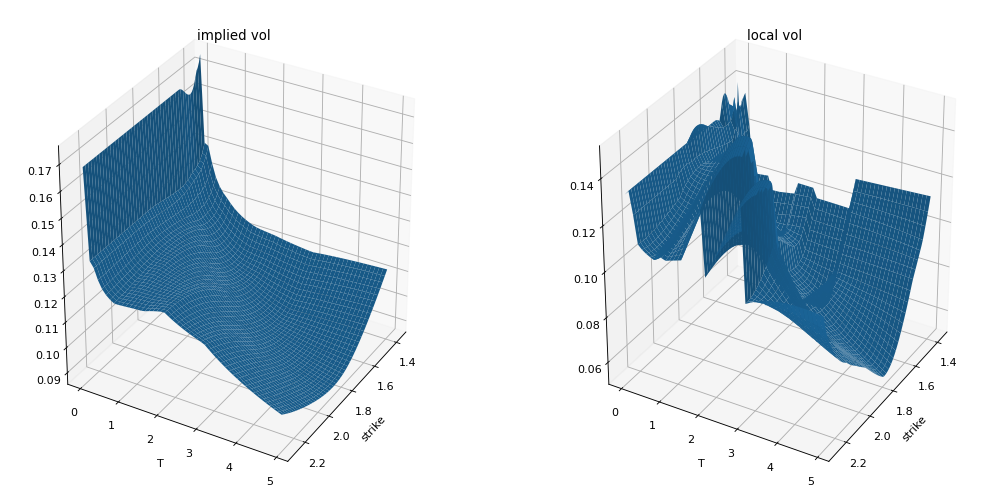

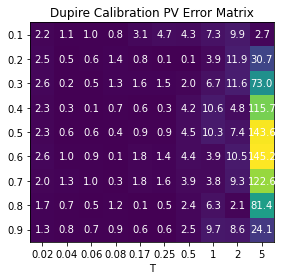

In [63]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, df= data,smileInterpMethod='AF')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)